# Summary
My hypothesis was that a neural network could be trained to predict the type of pitch that would be thrown by using a few variables describing the game state. 

Using models of varying sizes trained with all MLB pitches in 2024 I was unable to generate more accurate predictions than simply guessing "four-seam fastball" every time. I will assume that it is a 50/50 coin flip between my hypothesis being invalid, and my methodology being flawed. 

In the future it may be useful to isolate certain variables around game state. e.g., There may be more identifiable patterns for specific pitchers, or for two-strike / two-out situations. 

# Variables
The following features were used to train the model 

* Handedness of the pitcher and batter.
* Number of balls, strikes, and pitches seen during the at-bat.
* Number of outs in the current frame.  
* Which bases have runners on them. 

There are several variables in the statcast dataset like release location, spin rate, speed that are intentionally left out. The goal was to generate a model that could predict the pitch type BEFORE it was thrown. i.e., not to classify the pitch type based on data about the pitch itself.

# Importing the data and preprocessing
I used the daily Statcast CSV files from my GitHub repo. There were a few problematic rows that needed to be addressed. 

In [1]:
import os
import glob
import pandas as pd

os.chdir(os.path.expanduser('~/Documents/Baseball/StatcastData/statcast_csv'))
files = glob.glob('*.csv')
statcast_df = []
for file in files: 
    data = pd.read_csv(file)
    statcast_df.append(data)
statcast_df = pd.concat(statcast_df)

# There is one invalid row where the ball count is 4. We will just remove it
# otherwise the OneHotEncoding creates an entirely new column for counts with 
# 4 balls that is only set once in the 700k rows. 
statcast_df[statcast_df['balls'] == 4]
statcast_df = statcast_df[statcast_df['balls'] != 4]

# We are missing pitch clasification on ~300 pitches. It's a small enough number, we'll drop them
statcast_df['pitch_type'].isna().sum()
statcast_df = statcast_df.dropna(subset=['pitch_type'])

We are still working with over 700k pitches after removing the offending rows. 

The pitch distribution for the entire season is shown below. The most important abbreviaitions: FF = Four-seam fastball, CH = Changup, CU = Curveball, SI = Sinker, SL = Slider, ST = Sweeper. 

The conclusion was already offered above - our models only ended up being accurate 32% of the time. i.e., How often four-seam fastballs were thrown.  

In [2]:
# Pitch count
print(statcast_df.shape)

# Pitch distribution
statcast_df.groupby(['pitch_type']).size() / len(statcast_df) * 100

(705912, 94)


pitch_type
CH    10.250428
CS     0.001842
CU     6.579290
EP     0.060489
FA     0.081738
FC     8.025221
FF    31.649129
FO     0.021107
FS     3.019073
KC     1.635190
KN     0.134861
PO     0.007650
SC     0.021674
SI    16.040810
SL    16.425702
ST     5.680595
SV     0.365201
dtype: float64

In [3]:
# Subset the data to the columns we care about
feature_columns = ['stand', 'p_throws', 'balls', 'strikes', 
                   'on_1b', 'on_2b', 'on_3b', 
                   'outs_when_up', 'pitch_number']

X = statcast_df[feature_columns]
y = statcast_df['pitch_type']

# List of pitch types that are in our dataset
labels = y.unique()

Take a quick look at the feature variables. Notice that we are told which player is on base. We don't care about the player specifically, only if the base is occupied before the pitch is thrown. One of the transformations we will apply converts the on base columns to booleans indicating whether someone is there or not. 

In [4]:
X.head()

,stand,p_throws,balls,strikes,on_1b,on_2b,on_3b,outs_when_up,pitch_number
0,L,R,1,2,NaN,NaN,NaN,2,4
1,L,R,0,2,NaN,NaN,NaN,2,3
2,L,R,0,1,NaN,NaN,NaN,2,2
3,R,R,1,0,690993.0,663837.0,NaN,2,2
4,L,R,0,0,NaN,NaN,NaN,2,1


In [5]:
# Since the NAs are isolated to the three "on base" columns apply the transformation on the whole dataframe 
print(X.isna().sum())
X = X.fillna(0)

stand                0
p_throws             0
balls                0
strikes              0
on_1b           492126
on_2b           574608
on_3b           640349
outs_when_up         0
pitch_number         0
dtype: int64


In [6]:
X.isna().sum()

stand           0
p_throws        0
balls           0
strikes         0
on_1b           0
on_2b           0
on_3b           0
outs_when_up    0
pitch_number    0
dtype: int64

The data is split into 80%/10%/10% buckets for training/validation/testing respectively.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_tmp, y_train, y_tmp = \
    train_test_split(X, y, train_size=0.8, random_state=0)

X_valid, X_test, y_valid, y_test = \
    train_test_split(X_tmp, y_tmp, train_size=0.5, random_state=0)

Transform the features and target labels

In [8]:
from sklearn.preprocessing import Binarizer, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

# Switch the on base columns to booleans indicating if someone is on that base
# OneHot encode almost everything else (pitch_number is left as an integer)
transformer = make_column_transformer(
    (Binarizer(),['on_1b', 'on_2b', 'on_3b']),
    (OneHotEncoder(), ['stand', 'p_throws', 'balls', 'strikes', 'outs_when_up']),
    remainder='passthrough'
)

In [9]:
X_train = transformer.fit_transform(X_train)
X_valid = transformer.transform(X_valid)
X_test = transformer.transform(X_test)

input_shape = [X_train.shape[1]]

In [10]:
# Encode the target labels as a series of integers instead of the two letter codes. 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

In [11]:
y_train

array([ 6,  5, 15, ...,  5, 14,  6])

# Model Training
The first model is two layers deep with 64 nodes in each. It is configured to output probabilities that a given pitch type will be thrown. Early stopping was used to prevent overfitting. 

In [12]:
import setuptools.dist
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(labels), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    validation_data=(X_valid, y_valid),
                    batch_size = 512,
                    epochs=50,
                    callbacks=[early_stopping])

2025-01-03 15:54:55.445234: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2916 - loss: 2.0504 - val_accuracy: 0.3207 - val_loss: 1.8805
Epoch 2/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3150 - loss: 1.8975 - val_accuracy: 0.3207 - val_loss: 1.8771
Epoch 3/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3146 - loss: 1.8889 - val_accuracy: 0.3206 - val_loss: 1.8757
Epoch 4/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3158 - loss: 1.8882 - val_accuracy: 0.3208 - val_loss: 1.8748
Epoch 5/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3153 - loss: 1.8845 - val_accuracy: 0.3208 - val_loss: 1.8740
Epoch 6/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3161 - loss: 1.8849 - val_accuracy: 0.3213 - val_loss: 1.8731
Epoch 7/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3166 - loss: 1.8826 - val_accuracy: 0.3210 - val_loss: 1.8731
Epoch 8/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3159 - loss: 1.8831 - 

<Axes: >

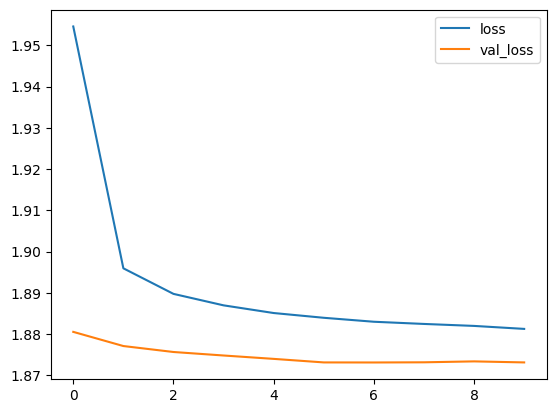

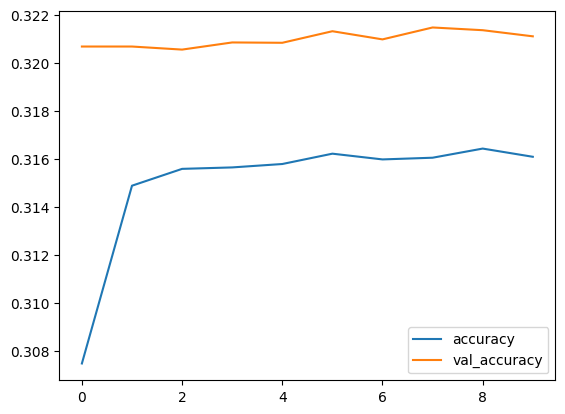

In [13]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:,['loss','val_loss']].plot()
history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()

The next few code blocks configured models of different sizes ranging from a single 16 node model to a much larger 4 x 512 node model. I didn't bother producing plots of the training accuracy as it looks like the training log is essentially the same for each, except the models had slightly different stopping points. 

In [14]:
histories = {}

tiny_model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(labels), activation='softmax')
])

tiny_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

histories['Tiny'] = tiny_model.fit(X_train, y_train, 
                        validation_data=(X_valid, y_valid),
                        batch_size = 512,
                        epochs=50,
                        callbacks=[early_stopping])



Epoch 1/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2457 - loss: 2.1853 - val_accuracy: 0.3207 - val_loss: 1.9168
Epoch 2/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3152 - loss: 1.9319 - val_accuracy: 0.3207 - val_loss: 1.8919
Epoch 3/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3152 - loss: 1.9115 - val_accuracy: 0.3207 - val_loss: 1.8850
Epoch 4/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3155 - loss: 1.9063 - val_accuracy: 0.3206 - val_loss: 1.8819
Epoch 5/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3158 - loss: 1.9024 - val_accuracy: 0.3207 - val_loss: 1.8813
Epoch 6/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3155 - loss: 1.9014 - val_accuracy: 0.3207 - val_loss: 1.8798
Epoch 7/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3157 - loss: 1.8984 - val_accuracy: 0.3207 - val_loss: 1.8792
Epoch 8/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3163 - loss: 1.8948 - 

In [15]:
small_model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(labels), activation='softmax')
])

small_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

histories['Small'] = small_model.fit(X_train, y_train, 
                        validation_data=(X_valid, y_valid),
                        batch_size = 512,
                        epochs=50,
                        callbacks=[early_stopping])

Epoch 1/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2377 - loss: 2.2729 - val_accuracy: 0.3207 - val_loss: 1.9092
Epoch 2/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3134 - loss: 1.9394 - val_accuracy: 0.3207 - val_loss: 1.8960
Epoch 3/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3145 - loss: 1.9200 - val_accuracy: 0.3207 - val_loss: 1.8916
Epoch 4/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3153 - loss: 1.9116 - val_accuracy: 0.3207 - val_loss: 1.8882
Epoch 5/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3152 - loss: 1.9087 - val_accuracy: 0.3207 - val_loss: 1.8859
Epoch 6/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3139 - loss: 1.9055 - val_accuracy: 0.3207 - val_loss: 1.8849
Epoch 7/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3158 - loss: 1.9023 - val_accuracy: 0.3207 - val_loss: 1.8829
Epoch 8/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3138 - loss: 1.9016 - 

In [16]:
medium_model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(labels), activation='softmax')
])

medium_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

histories['Medium'] = medium_model.fit(X_train, y_train, 
                    validation_data=(X_valid, y_valid),
                    batch_size = 512,
                    epochs=50,
                    callbacks=[early_stopping])

Epoch 1/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2833 - loss: 2.0832 - val_accuracy: 0.3206 - val_loss: 1.8820
Epoch 2/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3156 - loss: 1.8997 - val_accuracy: 0.3207 - val_loss: 1.8769
Epoch 3/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3151 - loss: 1.8936 - val_accuracy: 0.3207 - val_loss: 1.8753
Epoch 4/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3162 - loss: 1.8880 - val_accuracy: 0.3209 - val_loss: 1.8743
Epoch 5/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3154 - loss: 1.8874 - val_accuracy: 0.3208 - val_loss: 1.8753
Epoch 6/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3161 - loss: 1.8842 - val_accuracy: 0.3210 - val_loss: 1.8742
Epoch 7/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3146 - loss: 1.8859 - val_accuracy: 0.3215 - val_loss: 1.8739
Epoch 8/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3152 - loss: 1.8853 - 

In [17]:
large_model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(labels), activation='softmax')
])

large_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

histories['Large'] = large_model.fit(X_train, y_train, 
                    validation_data=(X_valid, y_valid),
                    batch_size = 512,
                    epochs=50,
                    callbacks=[early_stopping])

Epoch 1/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.3104 - loss: 1.9328 - val_accuracy: 0.3194 - val_loss: 1.8763
Epoch 2/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.3162 - loss: 1.8840 - val_accuracy: 0.3212 - val_loss: 1.8742
Epoch 3/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.3166 - loss: 1.8811 - val_accuracy: 0.3212 - val_loss: 1.8751
Epoch 4/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.3178 - loss: 1.8796 - val_accuracy: 0.3217 - val_loss: 1.8732
Epoch 5/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.3148 - loss: 1.8818 - val_accuracy: 0.3215 - val_loss: 1.8743
Epoch 6/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.3165 - loss: 1.8799 - val_accuracy: 0.3219 - val_loss: 1.8729
Epoch 7/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.3176 - loss: 1.8783 - val_accuracy: 0.3212 - val_loss: 1.8731
Epoch 8/50
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.3167 -

# Predictions
Now we generate some predictions from the first model. 

In [18]:
predictions = model.predict(X_test)

2206/2206 ━━━━━━━━━━━━━━━━━━━━ 2s 886us/step


It looks like a lot of four-seam fastball predictions (label #6).

In [19]:
import numpy as np
np.argmax(predictions, axis=1)

array([6, 6, 6, ..., 6, 6, 6])

In fact it is. 95% predicted to be fastball, and then roughly 2.5% predicted to be each sinker and slider. 

In [20]:

pd.DataFrame({'predictions': np.argmax(predictions,axis=1)}).groupby(['predictions']).size() / len(predictions) * 100


predictions
6     96.671011
13     3.328989
dtype: float64

In [21]:
print(le.classes_[6])
print(le.classes_[13])
print(le.classes_[14])

FF
SI
SL
